# Lab 2: Set Covering

Second lab + peer review. List this activity in your final report, it will be part of your exam.

## Task

Given a number $N$ and some lists of integers $P = (L_0, L_1, L_2, ..., L_n)$, 
determine, if possible, $S = (L_{s_0}, L_{s_1}, L_{s_2}, ..., L_{s_n})$
such that each number between $0$ and $N-1$ appears in at least one list

$$\forall n \in [0, N-1] \ \exists i : n \in L_{s_i}$$

and that the total numbers of elements in all $L_{s_i}$ is minimum. 

## Instructions

* Create the directory `lab2` inside the course repo (the one you registered with Andrea)
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)
* Use `problem` to generate the problems with different $N$
* In the `README.md`, report the the total numbers of elements in $L_{s_i}$ for problem with $N \in [5, 10, 20, 100, 500, 1000]$ and the total number on $nodes$ visited during the search. Use `seed=42`.
* Use `GitHub Issues` to peer review others' lab

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.

**Deadline**

* Sunday, November 6th 23:59:59 for the working solution
* Sunday, November 13th 23:59:59 for the peer reviews

In [384]:
import logging
import random
from time import time
from collections import namedtuple
from matplotlib import pyplot as plt

## Problem instances generator

In [385]:
def problem(N, seed=None):
    """Creates an instance of the problem"""

    random.seed(seed)
    return [
        list(set(random.randint(0, N - 1) for n in range(random.randint(N // 5, N // 2))))
        for n in range(random.randint(N, N * 5))
    ]

In [386]:
SET_COVERING_SIZE = 100      # Size = 5, 10, 20, 50, 100, 50, 1000
POPULATION_SIZE = 20000
OFFSPRING_SIZE = 500
NUM_GENERATIONS = 500


In [387]:
Individual = namedtuple("Individual", ["sol_covering", "fitness"])


def fitness_sol(solution):
    return sum(len(_) for _ in solution)


def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)


def cross_over(g1, g2):
    cut = random.randint(0, min(len(g1), len(g2))-1)
    return g1[:cut] + g2[cut:]

def mutation(g):
    point = random.randint(0, len(g) - 1)
    return g[:point] + g[point + 1 :]

def mutation1(g):
    point = random.randint(0, len(g) - 1)
    elem = g.copy()
    keeped = list()

    for i in range(len(elem)):
        if random.random() > 0.5:
            keeped.append(elem[i])

    return keeped

def is_valid(g):

    goal = set(range(SET_COVERING_SIZE))
    covered = set()
    for _ in g:
        covered |= set(_)

    return covered == goal

# Genetics algorithm

In [388]:
logging.getLogger().setLevel(logging.INFO)

## Initial Population

In [389]:
population = list()

def init_population(problem):

    population = list()

    for _ in range(POPULATION_SIZE):
        goal = set(range(SET_COVERING_SIZE))
        covered = set()
        sol_covering = list()
        lists_to_use = problem.copy()
        
        while goal != covered:
            to_pop = random.randint(0, len(lists_to_use)-1)
            x = lists_to_use.pop(to_pop)
            if not set(x) < covered:
                sol_covering.append(x)
                covered |= set(x)

        population.append(Individual(sol_covering, fitness_sol(sol_covering)))

    logging.info(f"init: pop_size={len(population)}; max={max(population, key=lambda i: i.fitness)[1]}; min={min(population, key=lambda i: i.fitness)[1]}")
    return population



## Evolution

In [390]:
population = init_population(problem(SET_COVERING_SIZE, seed=42))
fitness_log = [(0, i.fitness) for i in population]


start = time()

for g in range(NUM_GENERATIONS):
    offspring = list()
    for i in range(OFFSPRING_SIZE):
        if random.random() < 0.3:
            p = tournament(population)
            o = mutation1(p.sol_covering)
            if not is_valid(o):
                p1 = tournament(population)
                p2 = tournament(population)
                o = cross_over(p1.sol_covering, p2.sol_covering)
        else:
            p1 = tournament(population)
            p2 = tournament(population)
            o = cross_over(p1.sol_covering, p2.sol_covering)
        f = fitness_sol(o)
        fitness_log.append((g + 1, f))
        offspring.append(Individual(o, f))
    population += offspring
    population = sorted(population, key=lambda i: i.fitness)

end = time()


better = population[0]
print("Better solution: ", better)
print("Cost = ", better.fitness)
print("Bloat = ", (sum(len(_) for _ in better.sol_covering)-SET_COVERING_SIZE)/SET_COVERING_SIZE*100, "%")
print(f"Elapsed time: {end - start}s")



INFO:root:init: pop_size=20000; max=514; min=213


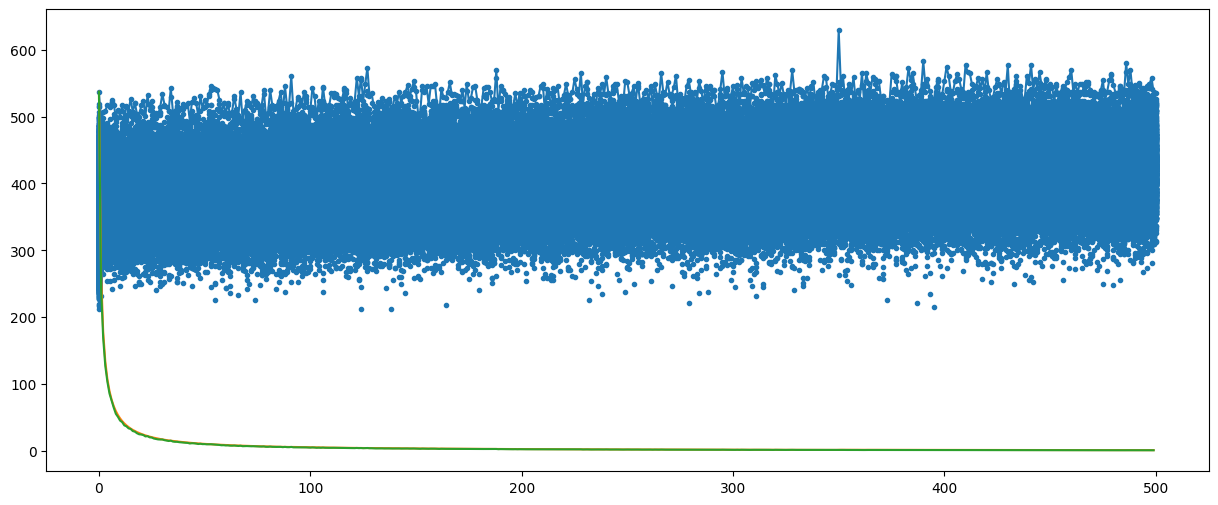

In [ ]:
off_line = [max(f[1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(NUM_GENERATIONS)]
on_line = [max(f[1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(NUM_GENERATIONS)]
gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(NUM_GENERATIONS)]

plt.figure(figsize=(15, 6))
plt.scatter([x for x, _ in fitness_log], [y for _, y in fitness_log], marker=".")
plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)])
plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)])
plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)])